In [1]:
import numpy as np
from scipy.optimize import minimize
from math import pi
from matplotlib import pyplot as plt

In [2]:
def R(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

In [3]:
class RotatedParabola:
    def __init__(self, a, h, k, theta):
        self.a = a
        self.h = h
        self.k = k
        self.theta = theta
        #graph is yp = a xp**2 where xp, yp if coordinate center at h,k rotated by theta

    def to_xp_yp(self, xs, ys): # convert to prime coordinate
        sx = xs - self.h # shift
        sy = ys - self.k
        r = np.array([sx, sy])
        xp, yp = np.dot(R(self.theta), r)  # rotate
        return xp, yp

    def to_x_y(self, xp, yp): # convert to original coordinate
        theta = self.theta
        R_inv = R(-theta)
        sx, sy = np.dot(R_inv, np.array([xp, yp]))
        return sx + self.h, sy + self.k
    
    def make_curve_from_x_y(self, start_x, start_y, end_x, end_y):
        theta = self.theta
        start_xp, _ = self.to_xp_yp(start_x, start_y)
        end_xp, _ = self.to_xp_yp(end_x, end_y)
        return self.make_curve_from_xp(start_xp, end_xp)

    def make_curve_from_xp(self, start_xp, end_xp, n=100, noise=0.):
        xp = np.linspace(start_xp, end_xp, n)
        yp = self.a * xp**2 + np.random.randn(n)*noise
        return self.to_x_y(xp, yp)

    def __str__(self):
        return f"RotatedParabola(a={self.a}, h={self.h:}, k={self.k}, theta={self.theta})"
    
    @classmethod
    def from_fit(cls, xs, ys, n_scan=360):
        # improving theta resolution by shifting to the meanx and meany
        mean_xs = np.mean(xs)
        mean_ys = np.mean(ys)
        nxs = (xs - mean_xs)
        nys = (ys - mean_ys)

        def full_cost(v):
            theta = v[0]
            r = np.array([nxs, nys])
            xp, yp = np.dot(R(theta), r)  # rotate
            p = np.polyfit(xp, yp, 2)  # fit (normal eq=faster)
            val = np.polyval(p, xp)
            return np.sum((val-yp)**2), p

        def cost(v):
            return full_cost(v)[0]

        # scan theta since the function is non convex in theta
        thetas = np.linspace(0, 2*pi+0.1, n_scan)
        costs = [cost([theta]) for theta in thetas]
        
        #plot to see it's very non convex in theta
        #plt.plot(thetas, costs)

        # use best theta as initial value for the fit
        ini_theta = thetas[np.argmin(costs)]
        res = minimize(cost, [ini_theta])
        best_theta, = res.x
        _, p = full_cost([best_theta])
        a, b, c = p

        # now convert a,b,c, theta it to a, k h, theta
        # high school math
        theta = best_theta
        a = a
        rh = -b/2/a  # k and h in rotated frame
        rk = c-b**2/4/a

        # invert h, k back to original axis
        h, k = np.dot(R(-theta), [rh, rk])

        # shift back to non mean axis
        h += mean_xs
        k += mean_ys

        return RotatedParabola(a, h, k, theta)

In [4]:
def sample_from_a_b_c_theta(a,b,c,theta, n=100, noise=0.5):
    xp = np.linspace(-5, 5, n)
    yp = a*xp**2 + b*xp + c + np.random.randn(n)*0.5
    R_inv = np.array([
        [np.cos(-theta), -np.sin(-theta)],
        [np.sin(-theta), np.cos(-theta)]
    ])
    rx ,ry = np.dot(R_inv, np.array([xp, yp]))
    return rx, ry

In [5]:
def sample_from_h_k_theta(a, h, k, theta, n=100, noise = 3.):
    xp = np.linspace(-5, 5, n)
    yp = a * xp**2 + np.random.randn(n)*noise

    R_inv = np.array([
        [np.cos(-theta), -np.sin(-theta)],
        [np.sin(-theta), np.cos(-theta)]
    ])
    
    sx, sy = np.dot(R_inv, np.array([xp, yp]))
    xs = sx + h
    ys = sy + k
    
    return xs, ys
    

RotatedParabola(a=-0.09880991570602465, h=2999.9757875444684, k=3000.068438097323, theta=4.199446577248121)


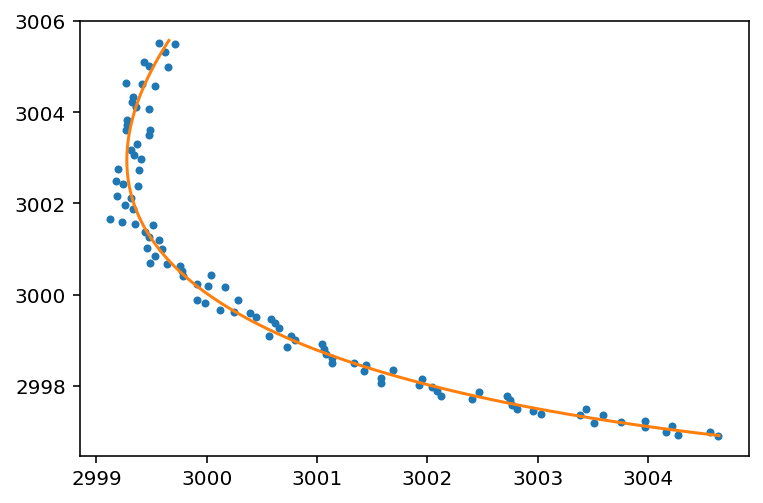

In [6]:
#xs, ys = sample_from_a_b_c_theta(1,2,3000,pi/3, noise=0.1)
np.random.seed(123)
xs, ys = sample_from_h_k_theta(0.1, 3000, 3000,pi/3, noise=0.1)

rp = RotatedParabola.from_fit(xs, ys)
fx, fy = rp.make_curve_from_x_y(xs[0], ys[0], xs[-1], ys[-1])
#fx, fy = rp.make_curve_from_xp(-100, 100)
print(rp)
#fx, fy = rp.
#fx, fy = sample(a, h, k, theta, noise=0.)


plt.figure()
plt.plot(xs , ys, '.')
plt.plot(fx, fy)

In [7]:
     
#     @classmethod
#     def from_fitting(cls, xs, ys, n_scan=360):
#         """Shift the whole graph by (h, k) then rotate then test
#         """
#         assert len(xs) == len(ys)
#         xs = np.array(xs, float)
#         ys = np.array(ys, float)

#         def find_best_a(k, h, theta):
#             sx = xs - h  # shifted x
#             sy = ys - k  # shifted y
#             r = np.array([sx, sy])

#             R = np.array([
#                 [np.cos(theta), -np.sin(theta)],
#                 [np.sin(theta), np.cos(theta)]
#             ])
#             xp, yp = np.dot(R, r)  # rotate
#             a = np.sum(yp*xp**2)/np.sum(xp**4)
#             residual = np.sum((yp - a*xp**2)**2)
            

#             return a, residual

#         def cost(v):
#             k, h, theta = v
#             a, residual = find_best_a(k, h, theta)
#             # note if we here to do rotate then shift we can do it much faster with normal eq.
#             # but the theta resolution will be sad and we will need to convert
#             # a,b,c back to a,k,h
#             return residual

#         def cost_fixed_theta(theta):
#             def c(v):
#                 k, h = v
#                 return cost([k, h, theta])
#             return c

#         thetas = np.linspace(0, pi, n_scan)
#         reses = []

#         # scan theta first since it's non convex here
#         for theta in thetas:
#             res = minimize(cost_fixed_theta(theta), [1., 1.])
#             k, h = res.x
#             #print(theta, res.fun, res.x, find_best_a(k, h, theta))
#             reses.append(res)
#         # try plot it here you will see it's highly non convex
#         rfun = [r.fun for r in reses]
#         plt.plot(thetas, rfun)

#         theta = thetas[np.argmin(rfun)]
#         k, h = res.x
#         a, _ = find_best_a(k, h, theta)
#         print(repr([a, k, h, theta]))
#         best_res = minimize(cost, [k, h, theta])
#         best_k, best_h, best_theta = best_res.x
#         best_a, _ = find_best_a(best_k, best_h, best_theta)
#         print(repr([best_a, best_k, best_h, best_theta]))
#         return best_a, best_k, best_h, best_theta